In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

# Damped Harmonic Oscillator
### Karen, Andreas and Clara

In this notebook, we apply a Physics-Informed Neural Network (PINN) to a 1D harmonic oscillator.

An example of a damped harmonic oscillator would be a mass attached to the end of a spring. 

When the mass is displaced from its equilibrium point (we define this as $x = 0$), the mass will oscillate periodically around this point. If the oscillations are damped, which we assume they are, the oscillations will cease and the mass will once again rest at its equilibrium point $x = 0$. 

The partial differential equation which governs the behaviour of the harmonic oscillator is:

$$
m \frac{d^2x}{dt^2} + \mu \frac{dx}{dt} + kx = 0
$$
Where m is the mass of the mass at the end of the spring, and k is the spring constant (Hooke's law). x indicates the displacement of the mass, and t is the time variable.

We impose the following initial conditions: at time $t = 0$, the mass is displaced from its equilibrium point, and the velocity of the mass is zero.

In equation form, 

$$
x(0) = 1, \frac{dx}{dt} = 0
$$

These initial conditions can be used to determine the exact solution of the system. We define two new variables to simplify the exact solution. These new variables are:
$$
\delta = \frac{\mu}{2m}, \omega_0 = \sqrt{ \omega_0^2 - \delta^2 }
$$

The exact solution can be written as: 
$$
x(t) = e^{-\delta t}(2A \cos(\phi + \omega t))
$$

with 

$$
A = \frac{1}{2 \cos\phi}, \phi = \tan^{-1}(\frac{\delta}{\omega})
$$

## Training a PINN
We have chosen to start training a PINN with a fully connected neural network which has 6 layers and 64 neurons in each of the hidden layers.


### Loss functions
We are using three losses to train our neural networks: a data loss, a physics loss, and a boundary conditions loss.

The data loss is just like any other neural network, where the predicted model output is compared to the actual data. The data loss aims to get the model output to match the datapoints as closely as possible, without regards to the physical reality of the solution. 

In our case, we can write the data loss as:
$$
loss_{data} = \frac{1}{N} \sum_i^N (xhat_{i} - x_{i})^2
$$
where x is the data points, and xhat is the prediction from the neural network.

The physics loss takes into account the governing PDE. During training, the physics loss aims to ensure that the governing PDE is respected in the model's predictions. 
$$
loss_{physics} =  \frac{1}{L} \sum_j^L ( m \frac{d^2x_j}{dt^2} + \mu \frac{dx_j}{dt} + kx_j )^2
$$

Finally, the initial/boundary conditions are also included in the loss term. These are needed because without this loss term, the neural network will often revert to a trivial solution, such as x = 0 over the whole time domain. The boundary conditions specify the specific problem we want to solve and this loss term forces the neural network to find a unique, non-trivial solution to the PDE. We can write these conditions for our case as:
$$
loss_{boundary} = (xhat(t = 0) - x(t = 0))^2 + (\frac{dxhat(t = 0)}{dt} - \frac{dx(t = 0)}{dt})^2
$$
Using the equations above, this simplifies to
$$
loss_{boundary} = (xhat(t = 0) - 1)^2 + (\frac{dxhat(t = 0)}{dt})^2
$$

The total loss is therefore equal to:

$$
loss_{total} =  \lambda_1 loss_{data} + \lambda_2 loss_{physics} + \lambda_3 loss_{boundary}
$$

where the lambdas are weighting factors which determine how the losses are weighted during training. These are usually determined by trial and error. 

### A note on training data
Before proceeding with training the network, it is important to distinguish between the different data arrays used in training. 

The data loss uses whichever data points are defined by the user. There are N of these data points in total. In our case, they are taken from the exact solution (but some Gaussian noise could also be added to test robustness of the model). We have decided to use only data points from the first half of the time domain (0 - 0.4 seconds), to see if the PINN can accurately predict the second half of the time domain. 

The physics loss is trained using the "physics collocation points". There are L of these points in total. This in an array of points of the whole time domain at which the physics loss is evaluted in each training step. Here it is important to include the whole time domain as this is what enables the PINN to follow the PDE in the entire domain. 

Finally the boundary conditions loss will usually only be trained with 1 or 2 points in low dimensions, but when moving to 2 dimensions this will more likely be an array defining input/output conditions. 

### Different ways to train the PINN

By uncommenting or including the individual terms in the definition of the loss term " loss = boundary loss + ...", you will be able to train the PINN with different loss.

Examples include:
- Training only with data. Then we see the neural network predicts well in the first half of the time domain (0 - 0.4), but fails to capture the lower amplitude oscillations in the second half of the time domain.
- Training with data + physics loss. When we include both these losses, the PINN is able to infer the behaviour in the second half of the time domain very well. It matches the analytical solution almost exactly. 
- Training with physics loss only. Here we observed that the PINN consistently predicted the trivial solution where x = 0 for the whole time domain. This makes sense as we did not include any information about the uniqueness of our case (data or initial conditions). 
- Training with physics loss + boundary loss. The PINN can once again reliably predict the oscillations of the mass on a spring across the whole time domain. 
- Training with physics loss + data loss + boundary loss. Same as above. As we start investigating PINNs with 2D problems, it will be important to include all three losses as they contribute to training a reliable model which predicts a realistic and non-trivial solution. 


### Sources
This notebook is inspired by: https://github.com/benmoseley/harmonic-oscillator-pinn/blob/main/Harmonic%20oscillator%20PINN.ipynb and
https://github.com/nanditadoloi/PINN/blob/main/solve_PDE_NN.ipynb and https://towardsdatascience.com/solving-differential-equations-with-neural-networks-afdcf7b8bcc4

### Analytical solution

In [2]:
def oscillator(d, w0, x):
    """Defines the analytical solution to the 1D underdamped harmonic oscillator problem. 
    Equations taken from: https://beltoforion.de/en/harmonic_oscillator/"""
    assert d < w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*x)
    sin = torch.sin(phi+w*x)
    exp = torch.exp(-d*x)
    y  = exp*2*A*cos
    return y

In [3]:
np.sqrt(800)

28.284271247461902

torch.Size([500, 1]) torch.Size([500, 1])
torch.Size([10, 1]) torch.Size([10, 1])


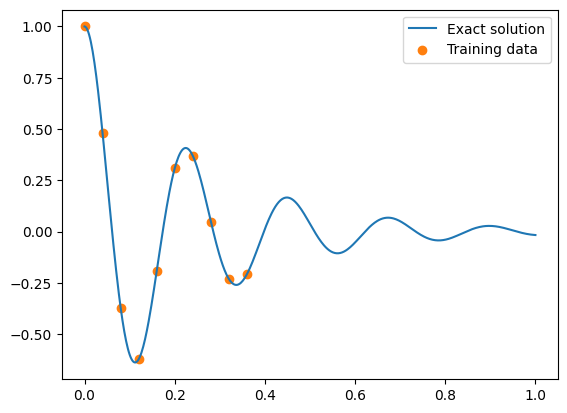

In [4]:
d, w0 = 4, np.sqrt(800)

# get the analytical solution over the full domain
x = torch.linspace(0,1,500).view(-1,1)
y = oscillator(d, w0, x).view(-1,1)
print(x.shape, y.shape)

# slice out a small number of points from the LHS of the domain
x_data = x[0:200:20]
y_data = y[0:200:20]
print(x_data.shape, y_data.shape)

plt.figure()
plt.plot(x, y, label="Exact solution")
plt.scatter(x_data, y_data, color="tab:orange", label="Training data")
plt.legend()
plt.show()

### Define Fully Connected Neural Network

In [5]:
class FullyConnected(nn.Module):
  def __init__(self, n_inputs, n_hidden, n_outputs):
    super().__init__()
    self.input = nn.Sequential(
      nn.Linear(n_inputs, n_hidden),
      nn.Tanh(),
    )
    
    self.hidden = nn.Sequential(
      nn.Linear(n_hidden, n_hidden),
      nn.Tanh(),
      nn.Linear(n_hidden, n_hidden),
      nn.Tanh(),
      nn.Linear(n_hidden, n_hidden),
      nn.Tanh(),
    )

    self.output = nn.Sequential(
    nn.Linear(n_hidden, n_hidden),
    nn.Tanh(),
    nn.Linear(n_hidden, n_outputs),
    )

  def forward(self, x):
    x = self.input(x)
    x = self.hidden(x)
    x = self.output(x)
    return x


### Define training points for data loss

In [6]:
d = 4
w0 = np.sqrt(800)

# get the analytical solution over the full domain
xs = torch.linspace(0, 1, 500).view(-1,1)
ys = oscillator(d, w0, xs).view(-1,1)

# slice out a small number of points from the LHS of the domain
xs_training = x[0:200:20]
ys_training = y[0:200:20]

### Define physics collocation points & train the PINN

tensor(0.2124, grad_fn=<AddBackward0>) tensor(1810.3522, grad_fn=<MeanBackward0>) tensor(0.0916, grad_fn=<MeanBackward0>)


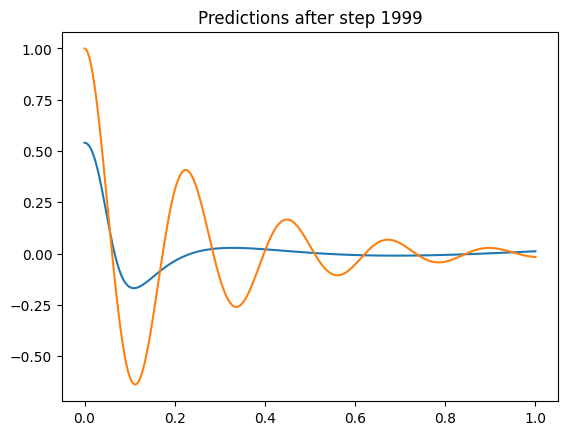

tensor(0.1515, grad_fn=<AddBackward0>) tensor(1497.7584, grad_fn=<MeanBackward0>) tensor(0.0753, grad_fn=<MeanBackward0>)


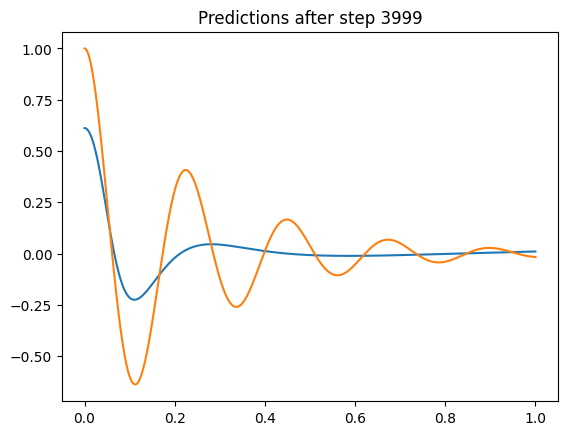

tensor(0.0324, grad_fn=<AddBackward0>) tensor(976.7460, grad_fn=<MeanBackward0>) tensor(0.0203, grad_fn=<MeanBackward0>)


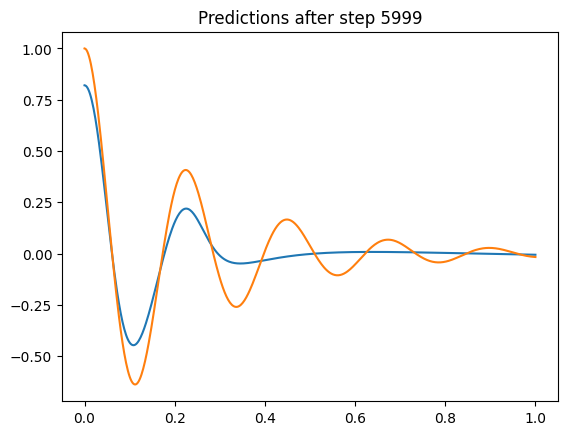

tensor(0.0646, grad_fn=<AddBackward0>) tensor(635.9158, grad_fn=<MeanBackward0>) tensor(0.0231, grad_fn=<MeanBackward0>)


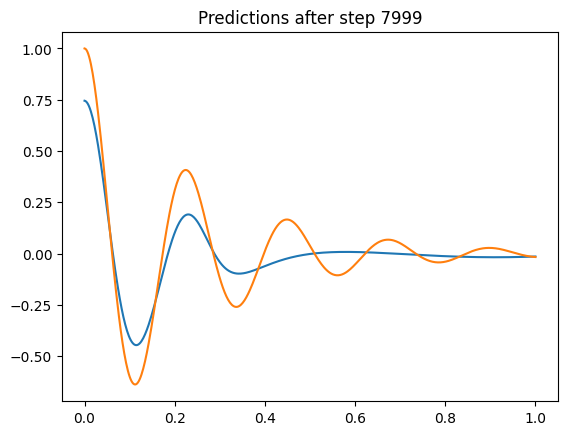

tensor(0.0034, grad_fn=<AddBackward0>) tensor(353.3408, grad_fn=<MeanBackward0>) tensor(0.0029, grad_fn=<MeanBackward0>)


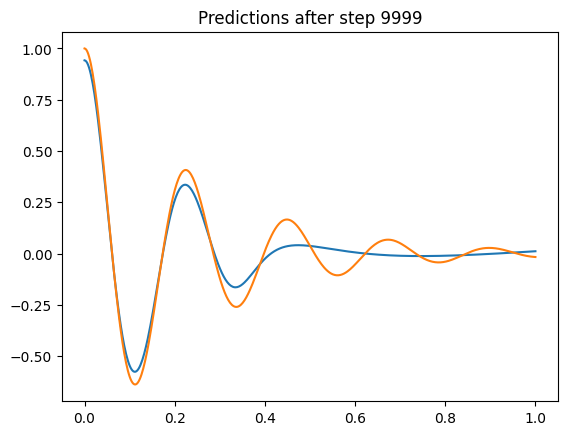

tensor(0.0028, grad_fn=<AddBackward0>) tensor(230.9593, grad_fn=<MeanBackward0>) tensor(0.0021, grad_fn=<MeanBackward0>)


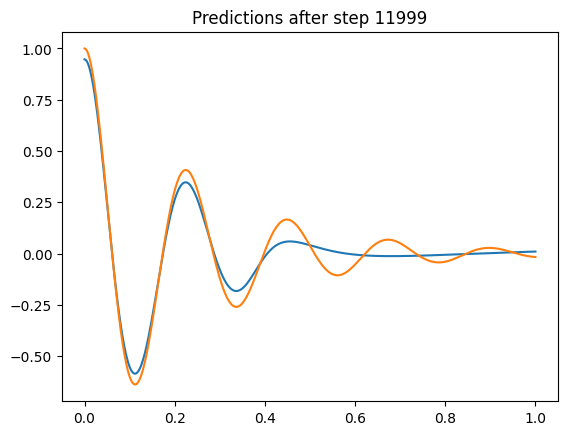

tensor(0.0535, grad_fn=<AddBackward0>) tensor(148.1122, grad_fn=<MeanBackward0>) tensor(0.0005, grad_fn=<MeanBackward0>)


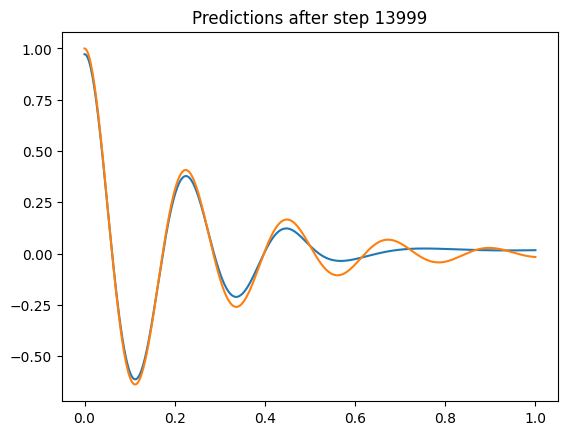

tensor(0.0030, grad_fn=<AddBackward0>) tensor(58.4512, grad_fn=<MeanBackward0>) tensor(0.0009, grad_fn=<MeanBackward0>)


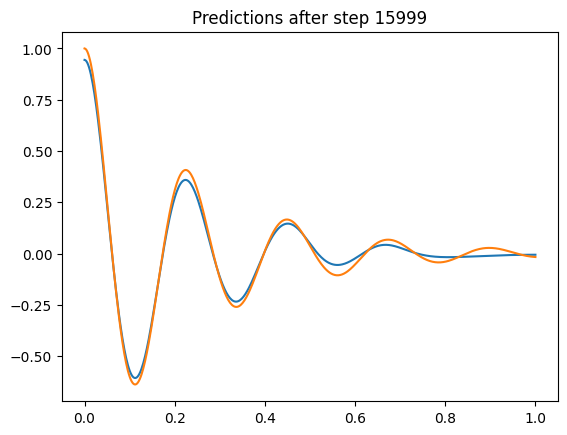

tensor(0.0141, grad_fn=<AddBackward0>) tensor(100.0368, grad_fn=<MeanBackward0>) tensor(0.0008, grad_fn=<MeanBackward0>)


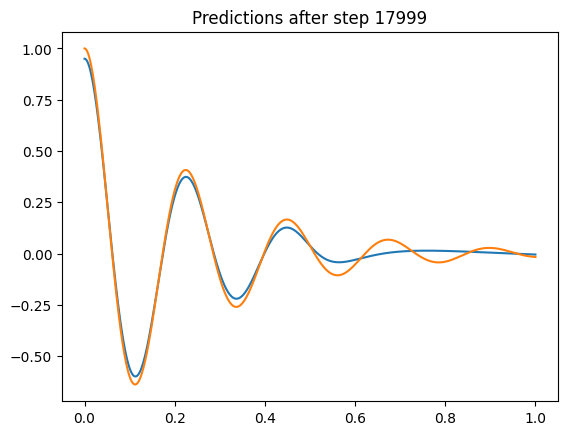

tensor(0.0008, grad_fn=<AddBackward0>) tensor(83.4276, grad_fn=<MeanBackward0>) tensor(0.0004, grad_fn=<MeanBackward0>)


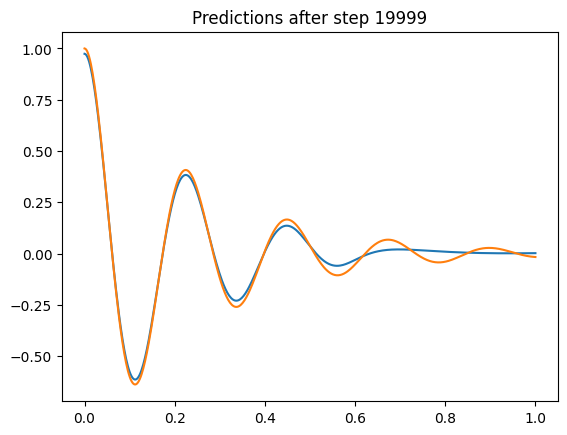

tensor(0.0249, grad_fn=<AddBackward0>) tensor(40.9775, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MeanBackward0>)


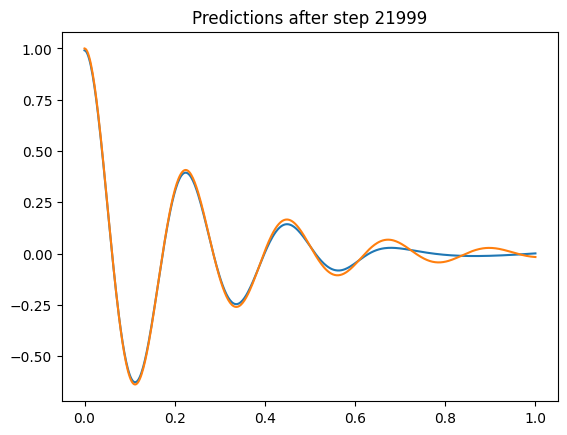

tensor(6.2769e-05, grad_fn=<AddBackward0>) tensor(31.9215, grad_fn=<MeanBackward0>) tensor(7.0067e-05, grad_fn=<MeanBackward0>)


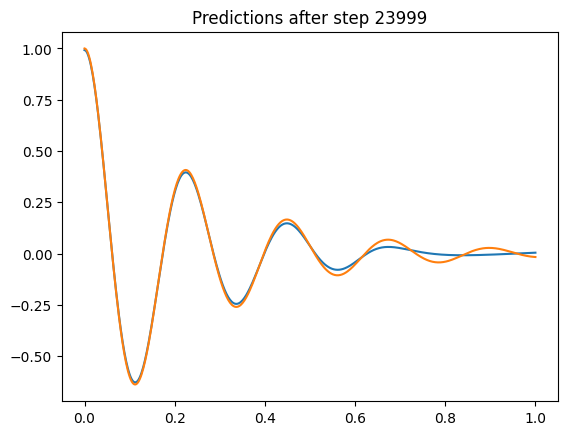

tensor(0.0035, grad_fn=<AddBackward0>) tensor(24.8688, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MeanBackward0>)


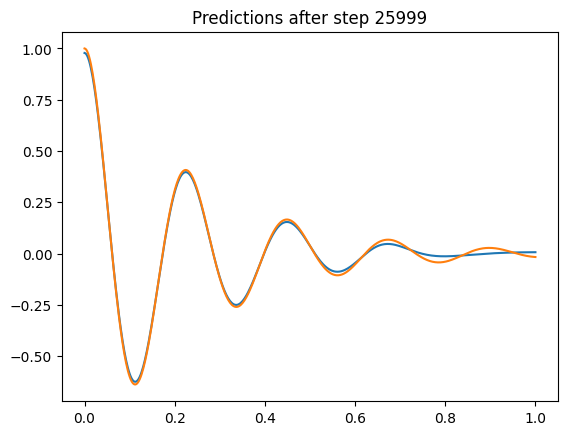

tensor(0.0316, grad_fn=<AddBackward0>) tensor(23.5214, grad_fn=<MeanBackward0>) tensor(4.5223e-05, grad_fn=<MeanBackward0>)


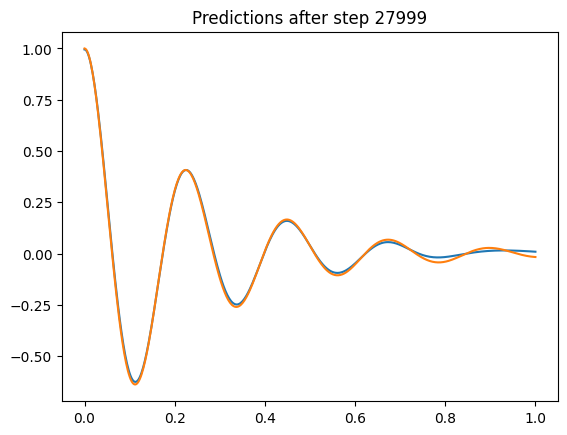

tensor(0.0020, grad_fn=<AddBackward0>) tensor(9.0421, grad_fn=<MeanBackward0>) tensor(1.3331e-05, grad_fn=<MeanBackward0>)


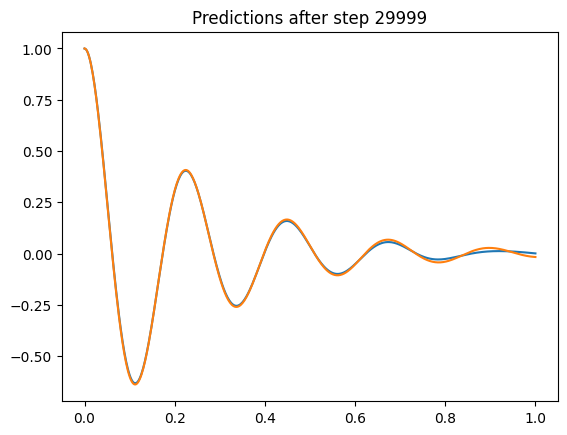

tensor(0.0087, grad_fn=<AddBackward0>) tensor(7.9867, grad_fn=<MeanBackward0>) tensor(1.5577e-05, grad_fn=<MeanBackward0>)


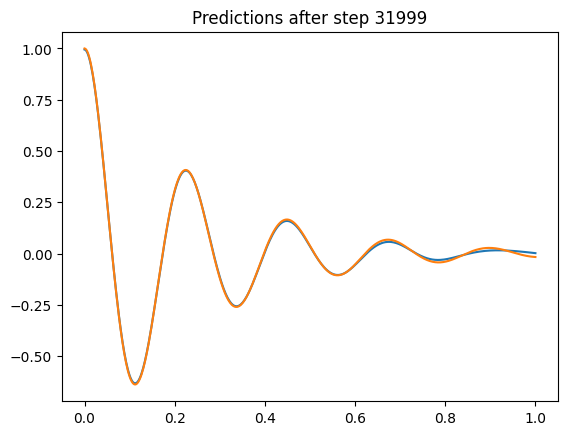

tensor(1.0637e-05, grad_fn=<AddBackward0>) tensor(5.4919, grad_fn=<MeanBackward0>) tensor(8.3425e-06, grad_fn=<MeanBackward0>)


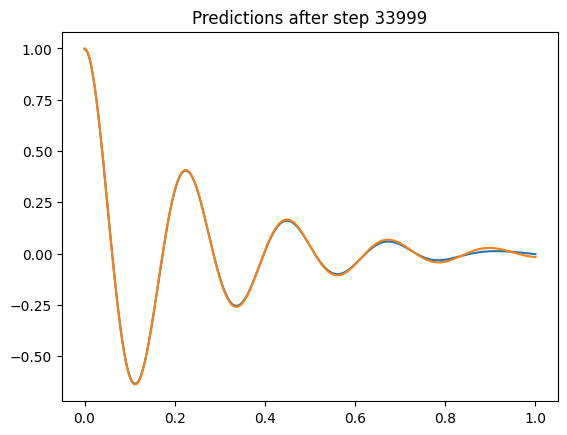

tensor(0.0055, grad_fn=<AddBackward0>) tensor(11.1556, grad_fn=<MeanBackward0>) tensor(1.8983e-05, grad_fn=<MeanBackward0>)


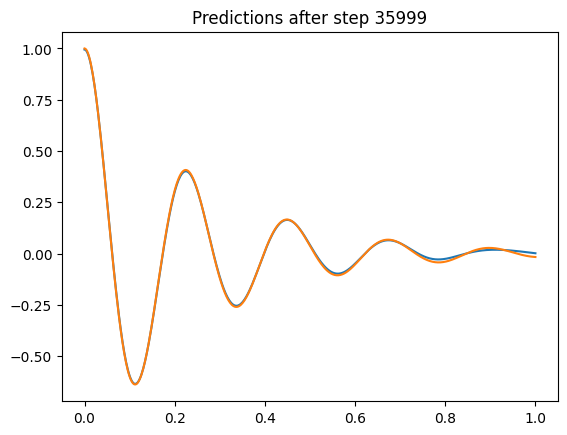

tensor(0.0012, grad_fn=<AddBackward0>) tensor(4.7085, grad_fn=<MeanBackward0>) tensor(3.9567e-06, grad_fn=<MeanBackward0>)


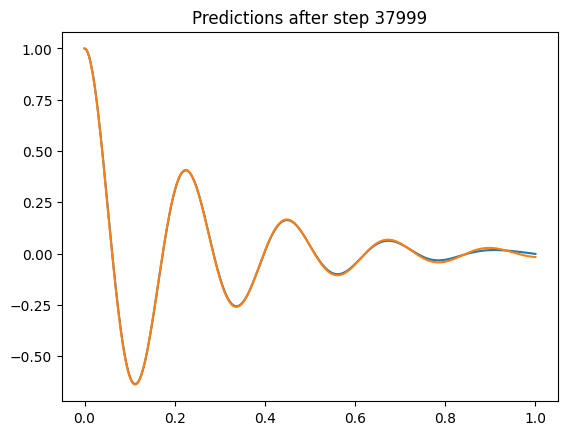

tensor(0.0026, grad_fn=<AddBackward0>) tensor(6.7795, grad_fn=<MeanBackward0>) tensor(2.2273e-05, grad_fn=<MeanBackward0>)


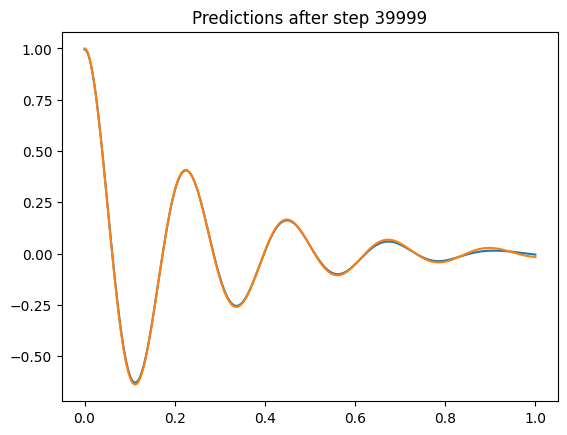

tensor(4.4398e-05, grad_fn=<AddBackward0>) tensor(3.8242, grad_fn=<MeanBackward0>) tensor(1.3249e-05, grad_fn=<MeanBackward0>)


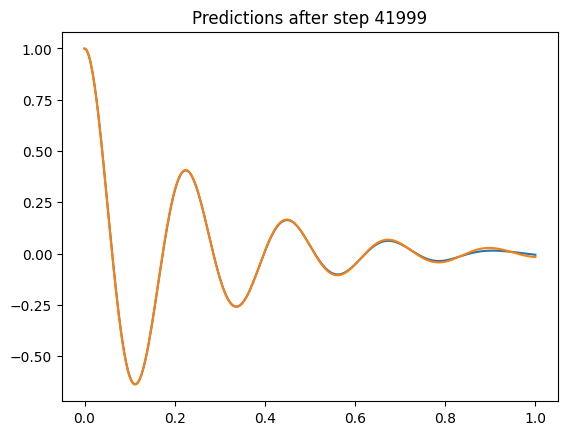

tensor(0.0049, grad_fn=<AddBackward0>) tensor(5.0772, grad_fn=<MeanBackward0>) tensor(7.2534e-06, grad_fn=<MeanBackward0>)


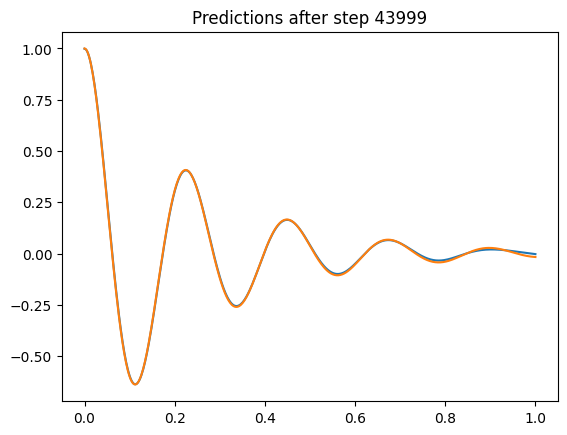

tensor(0.0014, grad_fn=<AddBackward0>) tensor(3.1339, grad_fn=<MeanBackward0>) tensor(1.9765e-05, grad_fn=<MeanBackward0>)


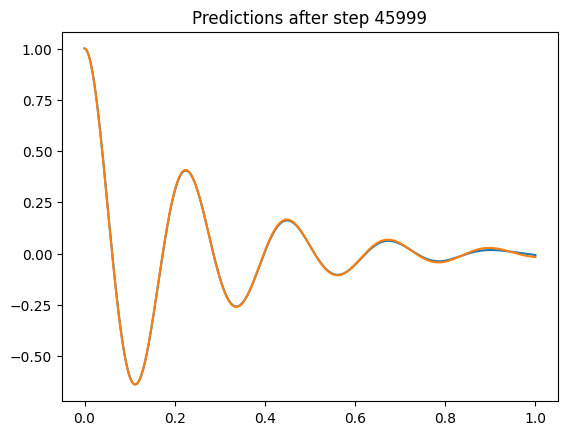

tensor(0.0031, grad_fn=<AddBackward0>) tensor(4.9707, grad_fn=<MeanBackward0>) tensor(1.5727e-05, grad_fn=<MeanBackward0>)


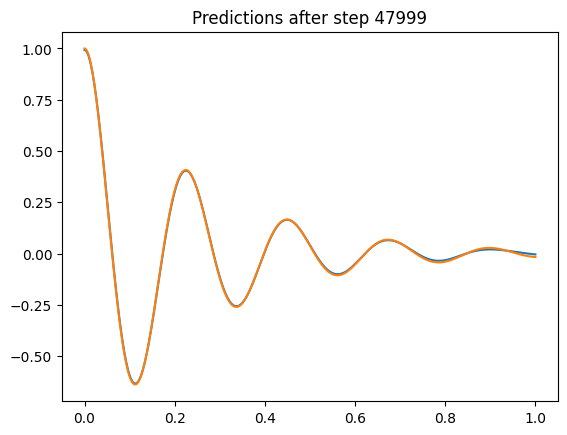

tensor(3.5144e-06, grad_fn=<AddBackward0>) tensor(3.1168, grad_fn=<MeanBackward0>) tensor(7.9735e-06, grad_fn=<MeanBackward0>)


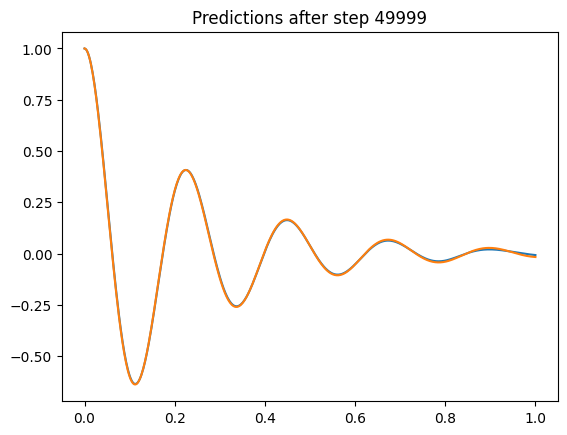

tensor(6.9864e-06, grad_fn=<AddBackward0>) tensor(3.2854, grad_fn=<MeanBackward0>) tensor(2.6406e-05, grad_fn=<MeanBackward0>)


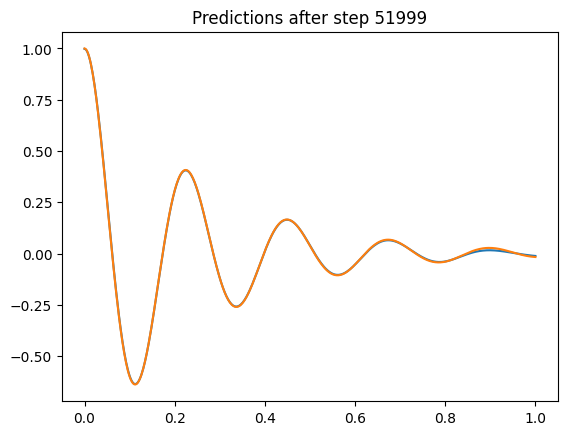

tensor(0.0023, grad_fn=<AddBackward0>) tensor(3.1689, grad_fn=<MeanBackward0>) tensor(1.5599e-05, grad_fn=<MeanBackward0>)


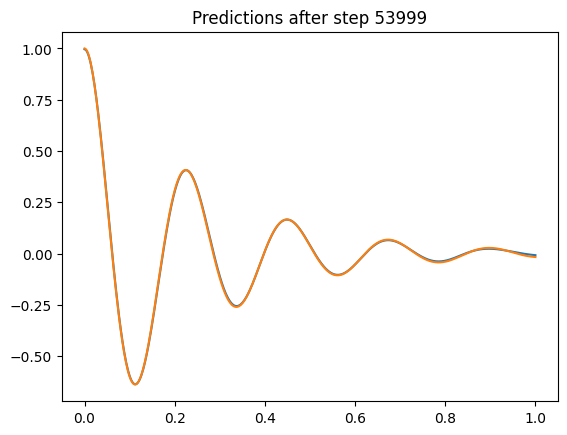

tensor(3.1598e-05, grad_fn=<AddBackward0>) tensor(1.3879, grad_fn=<MeanBackward0>) tensor(1.7352e-05, grad_fn=<MeanBackward0>)


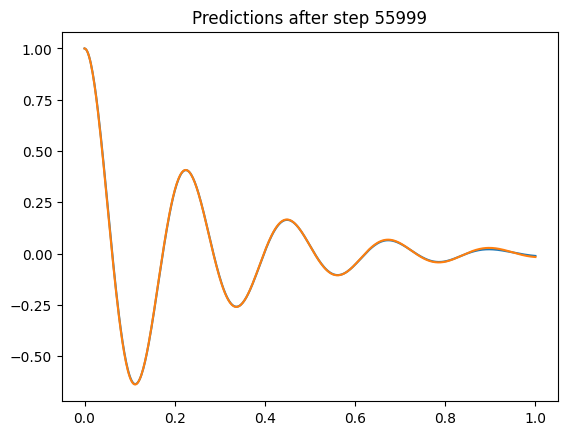

tensor(0.0026, grad_fn=<AddBackward0>) tensor(8.7724, grad_fn=<MeanBackward0>) tensor(9.1030e-05, grad_fn=<MeanBackward0>)


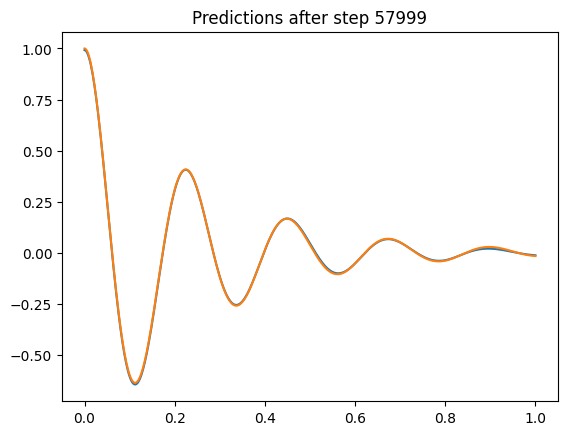

KeyboardInterrupt: 

In [7]:
physics_xs = torch.linspace(0, 1, 50).view(-1, 1).requires_grad_(True)

data_x = xs_training
data_y = ys_training

mu, k = 2*d, w0**2

torch.manual_seed(123)
model = FullyConnected(1, 64, 1)
optimizer2 = torch.optim.Adam(model.parameters(), lr=1e-3)#, weight_decay=1e-4)
scheduler = StepLR(optimizer2, step_size=10000, gamma=0.9)

for i in range(200000):
  optimizer2.zero_grad()

  # data loss
  pred_y = model(data_x)
  data_loss = torch.mean((pred_y - data_y) ** 2) # Mean squared error

  # physics loss
  physics_pred_y = model(physics_xs)
  dx = torch.autograd.grad(physics_pred_y, physics_xs, torch.ones_like(physics_pred_y), create_graph=True)[0]
  dx2 = torch.autograd.grad(dx, physics_xs, torch.ones_like(dx), create_graph=True)[0]
  residual = dx2 + mu * dx + k * physics_pred_y

  physics_loss = torch.mean(residual**2)

  # boundary conditions loss
  t_boundary = torch.zeros(1, requires_grad=True) # torch.tensor([0])
  x_boundary = torch.ones(1, requires_grad=True) #torch.tensor([1])
  # dx_boundary = torch.zeros(1, requires_grad=True) #torch.tensor([0])
  x0_predicted = model(t_boundary)
  dx_predicted = torch.autograd.grad(x0_predicted, t_boundary, torch.ones_like(t_boundary), create_graph=True)[0]
  residual_x0 = x0_predicted - x_boundary
  residual_dx = dx_predicted
  boundary_loss = torch.mean(residual_x0 ** 2) + torch.mean(residual_dx ** 2)

  # boundary_conditions_loss =

  loss = boundary_loss + (1e-4) * physics_loss #+ data_loss #data_loss + (1e-6)*physics_loss
  loss.backward()
  optimizer2.step()
  scheduler.step()

  if (i+1) % 2000 == 0:
    detached_t = physics_xs.detach()
    print(boundary_loss, physics_loss, data_loss)
    pred_ys = model(x).detach()
    plt.plot(x, pred_ys)
    plt.plot(x, y)
    # plt.scatter(detached_t, torch.zeros_like(detached_t))
    #plt.scatter(short_input_time, short_output_displacement)
    plt.title('Predictions after step '+str(i))
    plt.show()
